In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn import utils
import matplotlib.pyplot as plt
import shutil

# 定義路徑
data_dir = './Images/train'
train_dir = './dogdata/train'

# # 創建目標資料夾
# os.makedirs(train_dir, exist_ok=True)

# # 定義類別名稱
# classes = ['Samoyed', 'Siberian_husky', 'Maltese_dog', 'malamute', 'beagle', 'Eskimo_dog', 'redbone', 'Walker_hound']

# # 移動圖像到訓練資料夾
# for breed in classes:
#     breed_path = os.path.join(data_dir, breed)
#     images = os.listdir(breed_path)
    
#     os.makedirs(os.path.join(train_dir, breed), exist_ok=True)
    
#     for image in images:
#         shutil.copy(os.path.join(breed_path, image), os.path.join(train_dir, breed, image))

# print("資料移動完成！")

/home/e806/anaconda3/envs/naturalspeech/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision import transforms, datasets
import torch
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.Resize(128),
                                transforms.CenterCrop(128),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.ImageFolder(root=train_dir, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

classes = ['Samoyed', 'Siberian_husky', 'Maltese_dog', 'malamute', 'beagle', 'Eskimo_dog', 'redbone', 'Walker_hound']


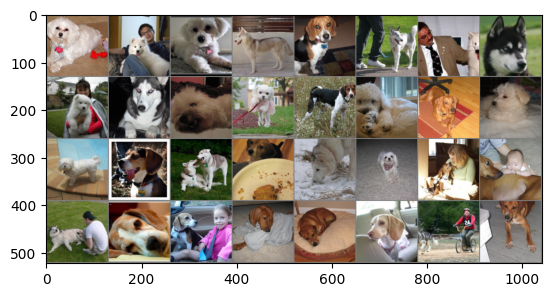

Siberian_husky Maltese_dog Siberian_husky Samoyed Eskimo_dog malamute Maltese_dog Samoyed


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# 定義顯示圖片的函數
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 獲取一些訓練數據
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 建立網格圖片
img_grid = make_grid(images)

# 顯示圖片
imshow(img_grid)

# 打印類別標籤
print(' '.join(f'{classes[labels[j]]}' for j in range(8)))


In [4]:
class GResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(GResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=8, timesteps=1000):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.timesteps = timesteps
        self.label_emb = nn.Embedding(num_classes, latent_dim)

        self.init_conv = nn.ConvTranspose2d(latent_dim * 2, 1024, 4, stride=1, padding=0)

        self.diffusion = nn.ModuleList([
            GResidualBlock(1024, 1024),
            GResidualBlock(1024, 1024),
            nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            GResidualBlock(512, 512),
            GResidualBlock(512, 512),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            GResidualBlock(256, 256),
            GResidualBlock(256, 256),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            GResidualBlock(128, 128),
            GResidualBlock(128, 128),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        ])

        self.timestep_embed = nn.Embedding(timesteps, latent_dim)

    def forward(self, z, labels, timesteps):
        c = self.label_emb(labels)
        t = self.timestep_embed(timesteps)
        x = torch.cat([z, c, t], 1)
        x = self.init_conv(x.view(-1, self.latent_dim * 2, 1, 1))

        for layer in self.diffusion:
            x = layer(x)

        return x[:z.size(0)]  # 返回與輸入批次大小相同的輸出

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = utils.spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding, bias=False))
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

class Discriminator(nn.Module):
    def __init__(self, num_classes=8):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes
        self.label_emb = nn.Embedding(num_classes, 1024)

        self.conv1 = utils.spectral_norm(nn.Conv2d(3, 64, 4, stride=2, padding=1))
        self.conv2 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128)
        )
        self.conv3 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256)
        )
        self.conv4 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512)
        )
        self.conv5 = nn.Sequential(
            ResidualBlock(512, 1024, stride=2),
            ResidualBlock(1024, 1024)
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.model = nn.Sequential(
            self.conv1,
            nn.LeakyReLU(0.2, inplace=True),
            self.conv2,
            self.conv3,
            self.conv4,
            self.conv5,
            self.adaptive_pool,
            nn.Flatten(),
        )

        self.out = nn.Sequential(
            nn.Linear(1024 * 4 * 4 + 1024, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        x = self.model(img)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        validity = self.out(x)
        return validity

In [6]:
import torch
import torch.nn as nn
import torch.nn.utils as utils
from tqdm import tqdm
import os
import copy
import logging
# 初始化最佳loss為正無窮
best_g_loss = float('inf')
# 訓練開始前建立目錄
os.makedirs("generated_images_dif_res", exist_ok=True)
os.makedirs("logs_dif_res", exist_ok=True)
# 設定超參數
latent_dim = 512
img_shape = (32, 32, 3)
lr = 0.002
b1 = 0.5
b2 = 0.999
num_epochs = 3000
batch_size = 64

# 初始化生成器和判別器
generator = Generator(latent_dim)
discriminator = Discriminator()

# 設定設備
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# 設定優化器
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr*0.001, betas=(b1, b2))

# 定義損失函數
criterion = nn.BCELoss()

# 生成固定的雜訊和標籤,用於生成圖像
fixed_noise = torch.randn(100, latent_dim, device=device)
fixed_labels = torch.randint(0, 8, (100,), device=device)

# 設定 logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(os.path.join("logs_dif_res", "training.log"))
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

d_losses = []
g_losses = []

# 訓練迴圈
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    epoch_d_losses = []
    epoch_g_losses = []
    for i, (imgs, labels) in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}", leave=False)):
        real_imgs = imgs.to(device)
        labels = labels.to(device)
        
        # 訓練判別器
        optimizer_D.zero_grad()
        
        # 真實圖像
        real_validity = discriminator(real_imgs, labels)
        d_real_loss = criterion(real_validity, torch.ones_like(real_validity))
        
        # 生成圖像
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_labels = torch.randint(0, 8, (batch_size,), device=device)
        timesteps = torch.randint(0, generator.timesteps, (batch_size,), device=device)  # 隨機選擇時間步
        gen_imgs = generator(z, gen_labels, timesteps)  # 將時間步傳遞給生成器
        fake_validity = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = criterion(fake_validity, torch.zeros_like(fake_validity))
        
        # 反向傳播與優化
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        # 訓練生成器
        optimizer_G.zero_grad()
        # 生成圖像
        fake_validity = discriminator(gen_imgs, gen_labels)
        g_loss = criterion(fake_validity, torch.ones_like(fake_validity))
        
        # 反向傳播與優化
        g_loss.backward()
        optimizer_G.step()
        
        # 檢查當前loss是否比最佳loss小
        if g_loss.item() < best_g_loss:
            best_g_loss = g_loss.item()
            # 深層copy當前生成器模型
            best_generator = copy.deepcopy(generator)
        # 打印訓練狀態
        if (i+1) % 100 == 0:
            print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i+1}/{len(trainloader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
    epoch_d_losses.append(d_loss.item())
    epoch_g_losses.append(g_loss.item())
    # 每10個 epoch 結束時生成圖像
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            timesteps = torch.randint(0, generator.timesteps, (100,), device=device)  # 隨機選擇時間步
            gen_imgs = generator(fixed_noise, fixed_labels,timesteps).detach().cpu()
            img_grid = torchvision.utils.make_grid(gen_imgs, nrow=10, normalize=True)
            plt.figure(figsize=(10,10))
            plt.imshow(img_grid.permute(1, 2, 0))
            plt.axis('off')
            plt.title(f"Epoch {epoch+1}")
            plt.savefig(f"generated_images_dif_res/epoch_{epoch+1}.png", bbox_inches='tight')
            plt.close()
    d_losses.append(sum(epoch_d_losses) / len(epoch_d_losses))
    g_losses.append(sum(epoch_g_losses) / len(epoch_g_losses))

    # 記錄當前 epoch 的平均損失值
    logger.info(f"Epoch {epoch + 1}/{num_epochs} - D loss: {d_losses[-1]:.4f} - G loss: {g_losses[-1]:.4f}")
# 繪製損失曲線
plt.figure(figsize=(10, 8))
plt.plot(range(num_epochs), d_losses, label='Discriminator Loss')
plt.plot(range(num_epochs), g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.savefig('training_losses.png')
plt.show()
# 在訓練結束後儲存最佳模型
torch.save(best_generator, 'best_generator_dif_res.pth')
torch.save(generator, 'final_generator_dif_res.pth')

Epochs:  44%|████▍     | 1322/3000 [5:44:06<7:16:46, 15.62s/it] 


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


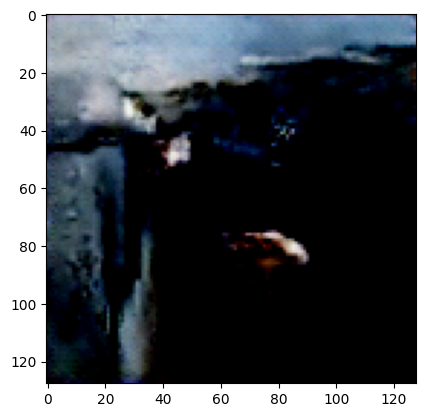

In [ ]:
# 載入保存的模型
loaded_generator = torch.load('final_generator_dif.pth')
# 設定到推理模式
loaded_generator.eval()  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 512
# 生成新圖像
noise = torch.randn(1, latent_dim, device=device)
label = torch.randint(0, 8, (1,), device=device)
with torch.no_grad():
    generated_img = loaded_generator(noise, label)
    
# 顯示生成的圖像
plt.imshow(generated_img.cpu().squeeze().permute(1, 2, 0))
plt.show()